# TESS Light Curves

The TESS *Ligh Curve* (LCf) file includes data processed from the *Target Pixel* file (TPf) we explored during the previous lecture. 
In the previous lectures, we extracted the TPf and the LCf from the *zipped* file downloaded from MAST and renamed the files for easier access. In my case, the star was observed during three sectors:

- Sector 23: TP file: `hatp44_tess_0023_tp.fits`; LC file: `hatp44_tess_0023_lc.fits`
- Sector 49: TP file: `hatp44_tess_0049_tp.fits`; LC file: `hatp44_tess_0049_lc.fits`
- Sector 50: TP file: `hatp44_tess_0050_tp.fits`; LC file: `hatp44_tess_0050_lc.fits`

The following steps will show in detail the procedure for the extraction of photometry for a single sector. You must repeat the process for each TESS sector at your disposal.

## Simple Aperture Photometry and Pre-search Data Conditioning Simple Aperture Photometry 

In aperture photometry, we sum the flux of several pixels belonging to the chosen aperture to produce a single flux value for our star. Before performing this operation, we must ensure that the background flux (e.g., scattered or reflected light by the atmosphere) is subtracted from the pixels in the aperture. This task is accomplished by computing the average background value per pixel using a different aperture. 
In the TASTE dataset, the aperture comprised all the pixels within the aperture radius from the star's centroid, while the background was computed on an annulus around the star. For TESS, the aperture and background pixels are selected within the available pixels in the Target Pixel file using a different algorithm. Still, aperture photometry is computed precisely in the same way. In the TESS dataset, the name **Simple Aperture Photometry (SAP)** identifies the aperture photometry.

**Pre-search Data Conditioning SAP (PDCSAP)** flux is the same aperture photometry extracted from the TPf,  with the additional removal of long-term trends and instrumental systematics using so-called Co-trending Basis Vectors (CBVs). \
 CBVs represent the set of systematic trends present in the ensemble flux data. CBVs are provided for each operational sector of the mission. These are derived by the TESS pipeline from a Principle Component Analysis and used to mitigate systematic artefacts within the target light curves. If TESS users see residual systematic problems within their light curve data, the CBVs can be employed in performing a manual photometric correction, more tailored towards the user's science.

PDCSAP flux is usually cleaner data than the SAP flux and has fewer systematic trends. However, in some cases, the correction may not be successful, see for example figure A1 in Appendix A of [Nardiello et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...664A.163N/abstract). Generally, checking the outcome of automatic corrections made by general-purposes pipelines is always a good practice. 

Many of the algorithms used by the TESS team have been developed for the Kepler mission, including the [Co-trending Basis Vectors correction](https://nexsci.caltech.edu/workshop/2012/keplergo/PyKEprimerCBVs.shtml).  More details can be found on the [TESS pipeline documentation page](https://heasarc.gsfc.nasa.gov/docs/tess/pipeline.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits 
%matplotlib widget
# use one of the two below if you are using jupyter notebook 
# %matplotlib inline 
# %matplotlib notebook

Let's proceed with checking the content of the LCf of the first sector at our disposal

In [2]:
path = 'MAST/'
sector71_lcf = path+'wasp12_tess_s0071_lc.fits'
fits.info(sector71_lcf)

Filename: MAST/wasp12_tess_s0071_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18677R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


Compared with the TPf, we have a smaller number of HDUs. 

- **No. 0 (Primary)**: This HDU contains meta-data related to the entire file.
- **No. 1 (Lightcurve)**: This HDU contains a binary table that has 11 columns containing a time series of either scalar values or images.
- **No. 2 (Aperture)**: This HDU contains an image that gives information about each pixel and how it was used by ther TESS pipeline in the data processing. This is the same as the target pixel file.

The extracted lightcurves are available in the second HDU, called `LIGHTCURVE`. We can see from the associated information that the HDU contains a Binary Table (`BinTable`) with 20 columns (the data of interest) and  19279 rows, each one corresponding to a cadence (exposure). 
The third HDU `APERTURE` reports the same information about the aperture contained in the TPf. This information can be used to check if the aperture and background masks used to compute the aperture photometry are the same as those recorded in the TPf.

We can now open the file and check the content of the second HDU (number 1, starting from 0 as Python convention) using the `columns` method.


In [3]:
lchdu = fits.open(sector71_lcf)
lchdu[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

In the case of the TPf, some rows ended with the declaration  
`dim = '(11,11)'`  
meaning that the information stored in each row of that specific columns was a matrix with shape 11x11. In this case, no such specification is listed, meaning that the stored array in each row is a single value, either in *unsigned byte* `B` (1 byte), *single precision float* `E` (32-bit, 4 bytes), or *double precision float* `D` (64-bit, 8 bytes).
The full list of allowed formats for a Bintable can be found in the [document defining the FITS standard](https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf) or in the [AstroPy documentation](https://docs.astropy.org/en/stable/io/fits/usage/table.html#column-creation). 

We can now identify the list of keywords corresponding to the infomration we want to extract from the LC File

| Name | Unit | Description |
| ---- | ---- | ----------- |
|`TIME` | Days | BJD - 2457000 (BTJD) |
`SAP_FLUX` | $e^–/s$ | Simple aperture photometry light curve. |
|`SAP_FLUX_ERR` | $e^–/s$ | 1-$\sigma$ uncertainty of the SAP light curve |
|`PDCSAP_FLUX` | $e^–/s$ | corrected SAP light curve. |
|`PDCSAP_FLUX_ERR` | $e^–/s$ | 1-$\sigma$ uncertainty of the PDC corrected SAP light curve. |
|`QUALITY` |Bit field| Quality flags, as bitmask |

The full description and additional information are available in the [TESS Science Data Products Description
Document](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/active-missions/tess/_documents/EXP-TESS-ARC-ICD-TM-0014-Rev-F.pdf). For example, in this document we can read that
> Subtracting TIMECORR from TIME will give the light arrival time at the spacecraft rather than at the barycenter. 

It means that the Light Travel Time correction is already included in the reported BJD_TDB. Unlike the TASTE case, we don't have to perform this correction ourselves.

We can access these arrays through the data attribute of the corresponding HDU:

In [4]:
sap_flux = lchdu[1].data['SAP_FLUX']
sap_flux_error = lchdu[1].data['SAP_FLUX_ERR']
pdcsap_flux = lchdu[1].data['PDCSAP_FLUX']
pdcsap_flux_error = lchdu[1].data['PDCSAP_FLUX_ERR']
quality_bitmask = lchdu[1].data['QUALITY']

Concerning the time of each exposure, from the comment in the column definition, we can see that an offset has been removed from each time stamp. This standard is usually referred as *Barycentric TESS Julian Date*. The documentation explains how to access the constant's value through the header of the fits file. From the documentation, we also get to know that the constant is divided into two parts, an integer one and a real one:


In [5]:
print('BJDREFI header value:  {1:d}, comment: {0:s}'.format(lchdu[1].header.comments['BJDREFI'], lchdu[1].header['BJDREFI']))
print('BJDREFF header value: {1:f}, comment: {0:s}'.format(lchdu[1].header.comments['BJDREFF'], lchdu[1].header['BJDREFF']))

BJDREFI header value:  2457000, comment: integer part of BTJD reference date
BJDREFF header value: 0.000000, comment: fraction of the day in BTJD reference date


To correctly retrieve the time array, we need to convert BTJD into BJD, i.e., adding back the subtracted constant:

In [6]:
time_array = lchdu[1].data['TIME'] + lchdu[1].header['BJDREFI'] +  lchdu[1].header['BJDREFF']

We can now plot the SAP and PDCSAP:

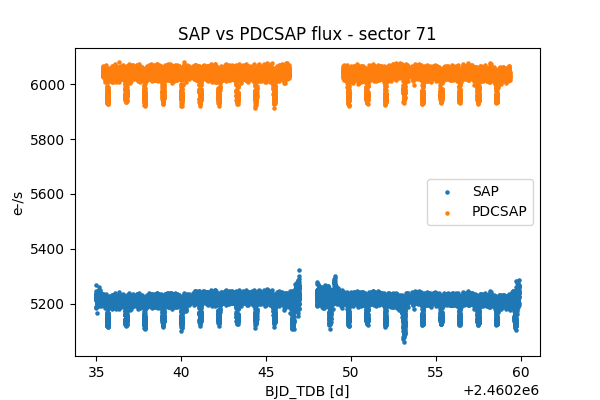

In [7]:
plt.figure(figsize=(6,4))
plt.scatter(time_array, sap_flux, s=5, label='SAP')
plt.scatter(time_array, pdcsap_flux, s=5, label='PDCSAP')
plt.xlabel('BJD_TDB [d]')
plt.ylabel('e-/s')
plt.title("SAP vs PDCSAP flux - sector 71")
plt.legend()
plt.show()

Apparently, the number of points in the PDCSAP is smaller than in the SAP. However, if we look at the shape of the two flux arrays, we can see that the number of points is the same. This latter fact makes sense as both arrays are plotted against the same array of epochs `time_array`.

In [8]:
print('Number of BJD epochs   :', np.shape(time_array))
print('Number of SAP epochs   :', np.shape(sap_flux))
print('Number of PDCSAP epochs:', np.shape(pdcsap_flux))

Number of BJD epochs   : (18677,)
Number of SAP epochs   : (18677,)
Number of PDCSAP epochs: (18677,)


What is the solution to this apparent inconsistency? If we print the elements of the  `pdcsap_flux` array that do not seem to have only the SAP counterpart in the plot, we can see that these values are all `nan`, which stands for *not a number*. A [*not a number*](https://en.wikipedia.org/wiki/NaN) (*nan* or *NaN*) is a particular value of a numeric data type that is undefined or unrepresentable, such as the result of zero divided by zero. Depending on the case, you may also get *inf*, standing for *infinite*. By default, `matplotlib` will not display these values, although they are still in your array.


In [9]:
print('Some elements of PDCSAP:', pdcsap_flux[10:20])

Some elements of PDCSAP: [nan nan nan nan nan nan nan nan nan nan]


When analyzing your data, you should exclude these values from the analysis, as some algorithms do not handle them well. 
Numpy provides several *logic* function to check the properties of your array: [`numpy.isnan`](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html) returns `True` when a value is a `nan`, [`numpy.isinf`](https://numpy.org/doc/stable/reference/generated/numpy.isinf.html) returns `True` if a value is `inf`, [`numpy.isfinite`](https://numpy.org/doc/stable/reference/generated/numpy.isfinite.html) is `True` if the value is neither `inf` or `nan`. 

Below, we construct a boolean array having `True`  values in correspondence with the finite values of the PDCSAP.

In [10]:
finite_selection = np.isfinite(pdcsap_flux)

We can now use the [Cadence Quality Flags](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview#id-2.0DataProductOverview-Table:CadenceQualityFlags) provided by TESS Team and stored as a bitmask (converted to an integer decimal number) in the `quality` array of the LCf.  
We can have a choice here: we can be *conservative* (or *pessimistic*) or *selective* (or *optimistic*):
1) in the *conservative* case, we exclude all the points that have *any* flag marked as True. Any possible problem among those listed on the Cadence Quality Flag page will cause the exclusion of the observation from our analysis
2) in the *selective* case, we decide which errors will exclude our observations from being considered.

For the first case, we just need to exclude all the observations with a quality flag greater than zero. We do it by marking as `True` al the observations qui quality bitmask greater than zero, and then by taking the opposite of this array through the operator `~`. We also need to exclude values that are not finite numbers. We apply the *AND* operator  `&` to ensure that both conditions (having a quality flag equal to zero and the value being finite) are simultaneously satisfied for the selection of the *good* data



In [11]:
conservative_selection =  ~(quality_bitmask > 0) & finite_selection


For the second case, we have to define a *reference bitmask* where we set as `1` (in binary notation) the flags that we want to use to exclude an observation and as `0` the flags we want to ignore. 
The easiest way to build this reference bitmask is to make a list of the conditions we want to check using the column *n Binary Digit* in the Cadence Quality Flags table and convert each of these flags into the corresponding value in the *Value* column, and sum all the values.  
Our reference bitmask is then compared with the quality bitmask of each observation. If *at least one* flag is marked as `True` in both the reference bitmask and the quality bitmask of the observation, then the observation will be marked as bad. 
We perform our final selection (good quality flag and finite value) in the same way as in the conservative case.


In [12]:
# This is an example of bit selection, it may not apply to your case
flags_to_be_checked = np.array([1,2,3,4,5,6,8,10,12,13,15,16])
reference_bitmask_in_decimal_system = 0
for v in flags_to_be_checked:
    reference_bitmask_in_decimal_system += 2**(v-1)

index_example_observation = 3
    
print('Value corresponding to the active flags {0:16d}'.format(reference_bitmask_in_decimal_system))
print('example quality bitmask                 {0:16d}'.format(quality_bitmask[index_example_observation]))
print()
print('binary representation of the selected flags    {0:16d}'.format(int(np.binary_repr(reference_bitmask_in_decimal_system))))
print('binary representation of the selected example  {0:16d}'.format(int(np.binary_repr(quality_bitmask[index_example_observation]))))
print()

print('Are we supposed to exclude this point?  {0:}'.format(np.bitwise_and(quality_bitmask[index_example_observation], reference_bitmask_in_decimal_system)> 0))

# bitwise comparison between the reference value and the quality flag
# each flag must be active in your selection AND active in the 
# at least one flag must be positive in order to esclude the point
selective_selection = ~(np.bitwise_and(quality_bitmask, reference_bitmask_in_decimal_system) > 0) & finite_selection


Value corresponding to the active flags            55999
example quality bitmask                              160

binary representation of the selected flags    1101101010111111
binary representation of the selected example          10100000

Are we supposed to exclude this point?  True


I strongly suggest the *conservative approach* for this laboratory, as you have many sectors and transits for your analysis. The *selective approach* may be required only in specific cases, e.g., when you really need observations at a given time, but the telescope is not behaving. In general, the conservative approach should always be preferred, as the inclusion of possibly problematic observations requires a deep knowledge of the instrument and the causes that lead to the rejection of some observations. 

Finally, remember to apply your selection to the time array as well, whenever necessary. 

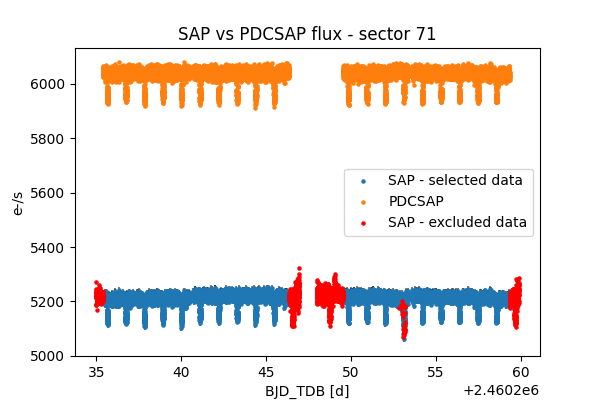

In [13]:
plt.figure(figsize=(6,4))
plt.scatter(time_array[conservative_selection], sap_flux[conservative_selection],
            s=5, label='SAP - selected data')
plt.scatter(time_array, pdcsap_flux, s=5, label='PDCSAP')
plt.scatter(time_array[~conservative_selection], sap_flux[~conservative_selection],
            s=5, c='r', label='SAP - excluded data')
plt.errorbar(time_array[conservative_selection], sap_flux[conservative_selection],
            yerr=sap_flux_error[conservative_selection], fmt=' ', alpha=0.5, 
            ecolor='k', zorder=-1)
plt.xlabel('BJD_TDB [d]')
plt.ylabel('e-/s')
plt.title("SAP vs PDCSAP flux - sector 71")

plt.legend()
plt.show()

We save our selected observations into `pickle` files, paying attention touse the correct sector number.

In [14]:
import pickle 

pickle.dump(time_array[conservative_selection], 
            open('output_files/wasp12_TESS_sector071_time.p','wb'))
pickle.dump(sap_flux[conservative_selection], 
            open('output_files/wasp12_TESS_sector071_sap_flux.p','wb'))
pickle.dump(sap_flux_error[conservative_selection], 
            open('output_files/wasp12_TESS_sector071_sap_flux_error.p','wb'))

pickle.dump(pdcsap_flux[conservative_selection], 
            open('output_files/wasp12_TESS_sector071_pdcsap_flux.p','wb'))
pickle.dump(pdcsap_flux_error[conservative_selection], 
            open('output_files/wasp12_TESS_sector071_pdcsap_flux_error.p','wb'))